# **About This Notebook**

In this kernel, I will do Exploratory Data Analysis, visualization on reviews using WordCloud, keywords extraction, and sentiment analysis.

***This kernel is a work in Progress,and I will keep on updating it as the competition progresses and I learn more and more things about the data***

<span style="color:red"><b>If you find this kernel useful, Please Upvote it , it motivates me to write more Quality content</b></span>

In [1]:
import re
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer
from collections import Counter

# Druglib.com Dataset

In [2]:
train_path = '/kaggle/input/patient-ratings-identifying-best-drugs/Drug Reviews (Druglib.com)/drugLibTrain_raw.csv'
test_path = '/kaggle/input/patient-ratings-identifying-best-drugs/Drug Reviews (Druglib.com)/drugLibTest_raw.csv'
df_druglib_train = pd.read_csv(train_path)
df_druglib_test = pd.read_csv(test_path)

In [3]:
df_druglib = pd.concat([df_druglib_train,df_druglib_test])
df_druglib = df_druglib.drop(columns='Unnamed: 0')
df_druglib.reset_index(drop=True,inplace=True)

In [4]:
df_druglib.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4143 entries, 0 to 4142
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   urlDrugName        4143 non-null   object
 1   rating             4143 non-null   int64 
 2   effectiveness      4143 non-null   object
 3   sideEffects        4143 non-null   object
 4   condition          4142 non-null   object
 5   benefitsReview     4120 non-null   object
 6   sideEffectsReview  4045 non-null   object
 7   commentsReview     4130 non-null   object
dtypes: int64(1), object(7)
memory usage: 259.1+ KB


In [5]:
# Dropping null values since only a few rows containing null values
df_druglib = df_druglib.dropna()
df_druglib.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4013 entries, 0 to 4142
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   urlDrugName        4013 non-null   object
 1   rating             4013 non-null   int64 
 2   effectiveness      4013 non-null   object
 3   sideEffects        4013 non-null   object
 4   condition          4013 non-null   object
 5   benefitsReview     4013 non-null   object
 6   sideEffectsReview  4013 non-null   object
 7   commentsReview     4013 non-null   object
dtypes: int64(1), object(7)
memory usage: 282.2+ KB


In [6]:
df_druglib.head()

,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above


In [7]:
df_druglib.describe()

,rating
count,4013.000000
mean,6.940693
std,2.932520
min,1.000000
25%,5.000000
50%,8.000000
75%,9.000000
max,10.000000


# Druglib.com EDA on Correlation of Drug's Effectiveness, Side Effects, and Ratings

In [8]:
df_druglib['effectiveness'].unique()

array(['Highly Effective', 'Marginally Effective', 'Ineffective',
       'Considerably Effective', 'Moderately Effective'], dtype=object)

In [9]:
df_druglib['sideEffects'].unique()

array(['Mild Side Effects', 'Severe Side Effects', 'No Side Effects',
       'Extremely Severe Side Effects', 'Moderate Side Effects'],
      dtype=object)

In [10]:
# Map effectiveness column into ordinal data
effectiveness_map = {
    'Ineffective': 1,
    'Marginally Effective': 2,
    'Moderately Effective': 3,
    'Considerably Effective': 4,
    'Highly Effective': 5
}

df_druglib['effectiveness_rank'] = df_druglib['effectiveness'].map(effectiveness_map)

In [11]:
# Map sideEffects column into ordinal data
sideEffects_map = {
    'No Side Effects': 1,
    'Mild Side Effects': 2,
    'Moderate Side Effects': 3,
    'Severe Side Effects': 4,
    'Extremely Severe Side Effects': 5
}

df_druglib['sideEffects_rank'] = df_druglib['sideEffects'].map(sideEffects_map)

In [12]:
df_druglib[['effectiveness','effectiveness_rank']].drop_duplicates().sort_values(by='effectiveness_rank')

,effectiveness,effectiveness_rank
5,Ineffective,1
3,Marginally Effective,2
16,Moderately Effective,3
7,Considerably Effective,4
0,Highly Effective,5


In [13]:
df_druglib[['sideEffects','sideEffects_rank']].drop_duplicates().sort_values(by='sideEffects_rank')

,sideEffects,sideEffects_rank
2,No Side Effects,1
0,Mild Side Effects,2
10,Moderate Side Effects,3
1,Severe Side Effects,4
9,Extremely Severe Side Effects,5


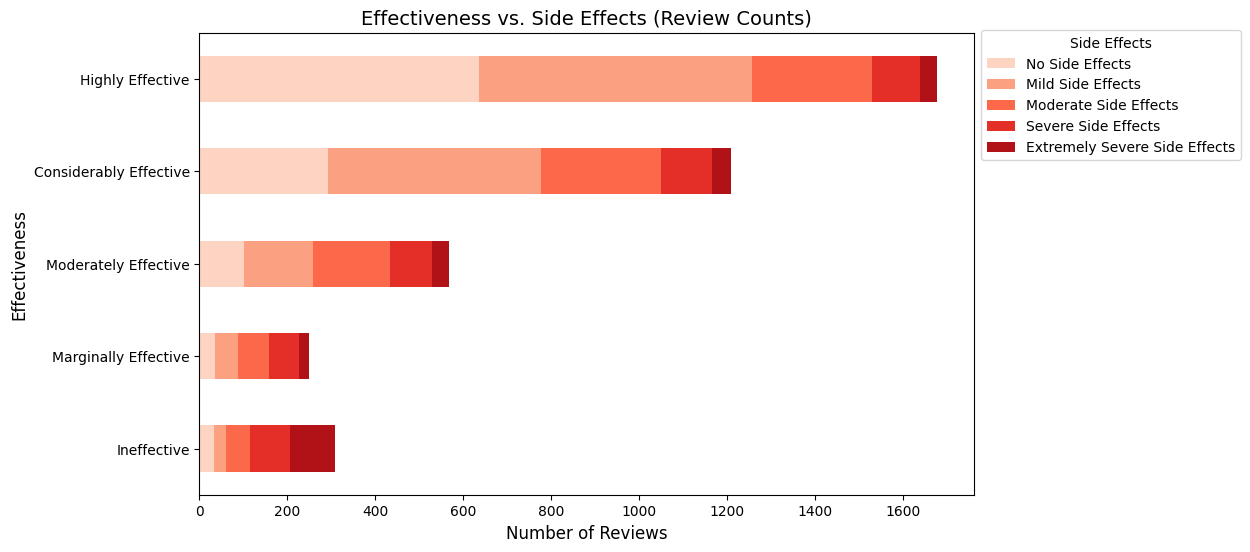

In [14]:
# Plotting horizontal bar chart to show drug's effectiveness and side effects distribution
effectiveness_order = [
    'Ineffective',
    'Marginally Effective',
    'Moderately Effective',
    'Considerably Effective',
    'Highly Effective'
]

sideEffects_order = [
    'No Side Effects',
    'Mild Side Effects',
    'Moderate Side Effects',
    'Severe Side Effects',
    'Extremely Severe Side Effects'
]

sideEffects_color = sns.color_palette("Reds", len(sideEffects_order))
data_bar1 = df_druglib.pivot_table(index='effectiveness',columns='sideEffects',values='commentsReview',aggfunc='count')
data_bar1 = data_bar1.reindex(index=effectiveness_order,columns=sideEffects_order)

ax = data_bar1.plot(kind='barh',stacked=True,color=sideEffects_color,figsize=(10, 6))

plt.title('Effectiveness vs. Side Effects (Review Counts)', fontsize=14)
plt.ylabel('Effectiveness', fontsize=12)
plt.xlabel('Number of Reviews', fontsize=12)

# Customize legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='Side Effects', bbox_to_anchor=(1,1.02), loc='upper left')

plt.show()

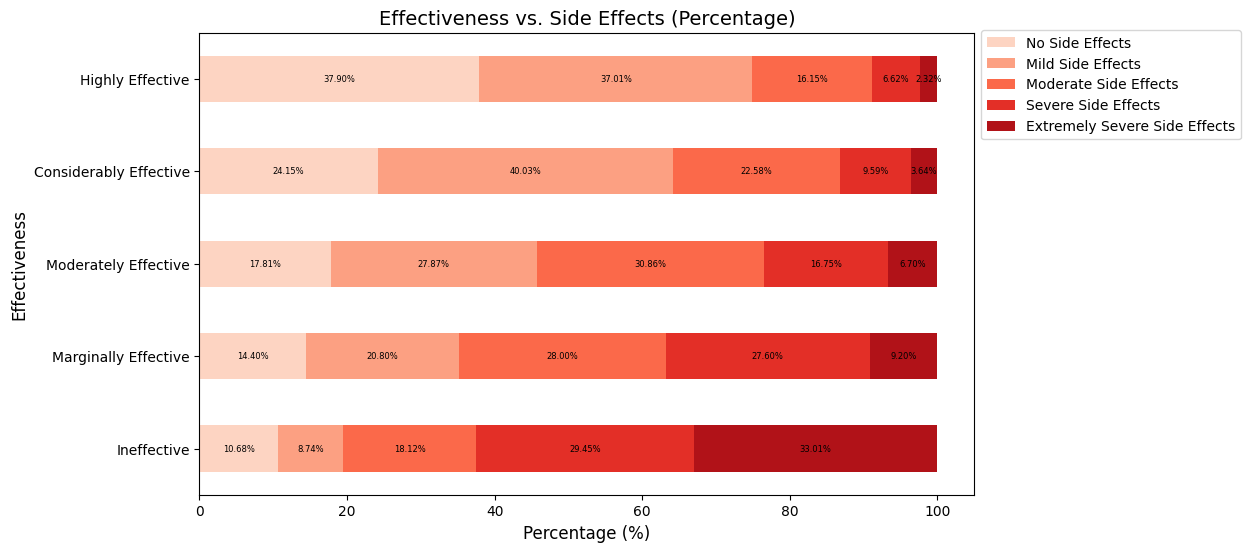

In [15]:
# Calculate row-wise sum for normalization
row_sums = data_bar1.sum(axis=1)

# Calculate percentages
data_percent = data_bar1.div(row_sums, axis=0) * 100

# Plotting
ax = data_percent.plot.barh(stacked=True,color=sideEffects_color,figsize=(10, 6))
plt.title('Effectiveness vs. Side Effects (Percentage)', fontsize=14)
plt.ylabel('Effectiveness', fontsize=12)
plt.xlabel('Percentage (%)', fontsize=12)

for c in ax.containers:

    # customize the label to account for cases when there might not be a bar section
    labels = [f'{w:.2f}%' if (w := v.get_width()) > 0 else '' for v in c ]

    # set the bar label
    ax.bar_label(c, labels=labels, label_type='center', fontsize=6)

ax.legend(bbox_to_anchor=(1,1.02), loc='upper left')

plt.show()

In [16]:
data_bar1

sideEffects,No Side Effects,Mild Side Effects,Moderate Side Effects,Severe Side Effects,Extremely Severe Side Effects
effectiveness,,,,,
Ineffective,33,27,56,91,102
Marginally Effective,36,52,70,69,23
Moderately Effective,101,158,175,95,38
Considerably Effective,292,484,273,116,44
Highly Effective,636,621,271,111,39


In [17]:
data_percent

sideEffects,No Side Effects,Mild Side Effects,Moderate Side Effects,Severe Side Effects,Extremely Severe Side Effects
effectiveness,,,,,
Ineffective,10.679612,8.737864,18.122977,29.449838,33.009709
Marginally Effective,14.400000,20.800000,28.000000,27.600000,9.200000
Moderately Effective,17.813051,27.865961,30.864198,16.754850,6.701940
Considerably Effective,24.152192,40.033085,22.580645,9.594706,3.639371
Highly Effective,37.902265,37.008343,16.150179,6.615018,2.324195


Does effectiveness correlate with side effects? **Yes, it does!** The data shows that as **drug effectiveness rises**, **severe side effects decline** while **no or mild side effects increase** notably, with highly effective drugs showing the most favorable profile.

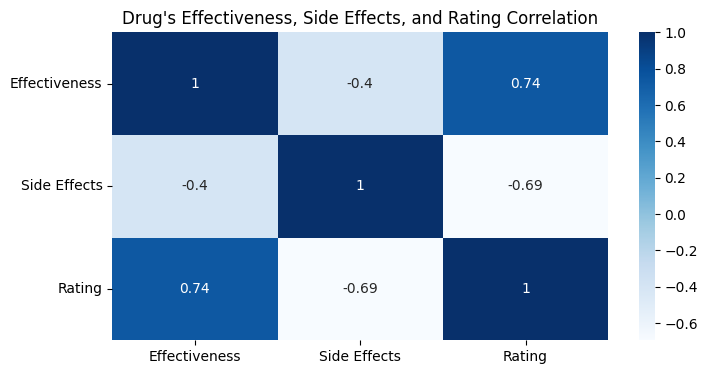

In [18]:
# Plot heatmap
plt.figure(figsize=(8, 4))
heatmap = sns.heatmap(df_druglib[['effectiveness_rank','sideEffects_rank','rating']].corr(), annot=True, cmap='Blues', cbar=True)

# Custom x and y labels
x_labels = ['Effectiveness', 'Side Effects', 'Rating']
y_labels = ['Effectiveness', 'Side Effects', 'Rating']

# Set the x and y labels
heatmap.set_xticklabels(x_labels, rotation=0)
heatmap.set_yticklabels(y_labels, rotation=0)

plt.title("Drug's Effectiveness, Side Effects, and Rating Correlation")

plt.show()

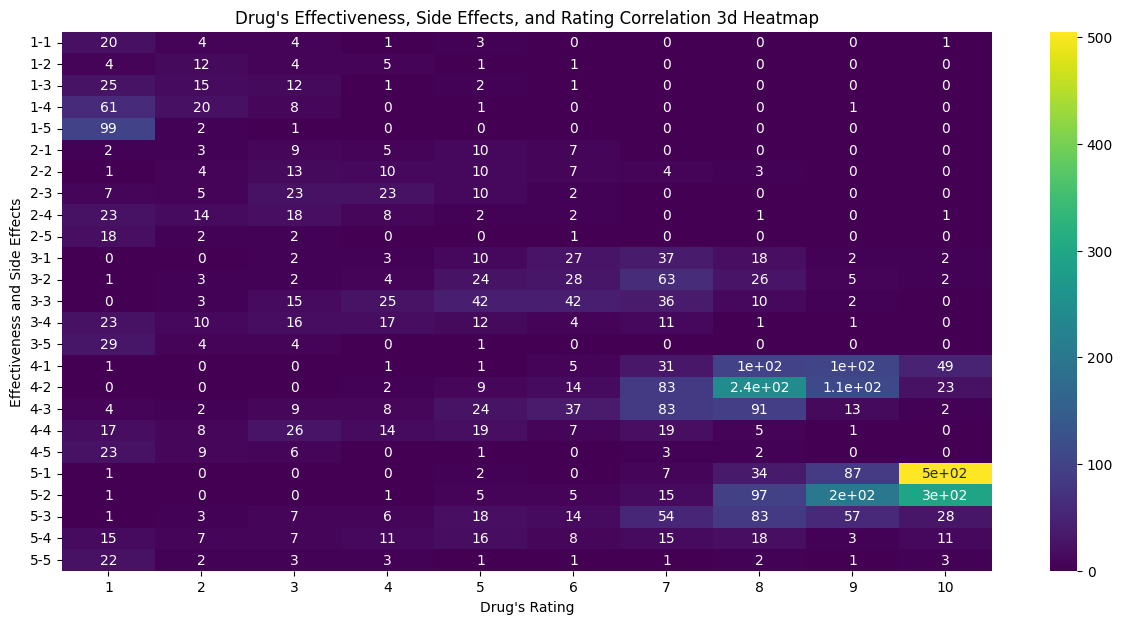

In [19]:
# Cross-tabulate the data
heatmap_data = pd.crosstab(index=[df_druglib['effectiveness_rank'], df_druglib['sideEffects_rank']], columns=df_druglib['rating'])

# Plot heatmap
plt.figure(figsize=(15, 7))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', cbar=True)

plt.xlabel("Drug's Rating")
plt.ylabel('Effectiveness and Side Effects')
plt.title("Drug's Effectiveness, Side Effects, and Rating Correlation 3d Heatmap")

plt.show()

What about ratings given by the consumer? It is shown that **rating has positive correlation with effectiveness** while having a **negative correlation with side effects**. Also, the effectiveness of a drug has a slightly stronger correlation than side effects, meaning that Highly Effective drugs will probably guarantee their ratings no less than 7.

# Druglib.com Data Preprocessing

In [20]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

def split_text(text):
    return text.split(' ')

def preprocess_text(text):
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    words = word_tokenize(text)  # Tokenize
    words = [word for word in words if word not in stop_words]  # Remove stopwords and stem
    return ' '.join(words)

df_druglib['cleaned_reviews'] = df_druglib['commentsReview'].apply(preprocess_text)
df_druglib['cleaned_benefits'] = df_druglib['benefitsReview'].apply(preprocess_text)
df_druglib['cleaned_sideEffects'] = df_druglib['sideEffectsReview'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [21]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

def sentiment_analyzer(df,text_column):
    # Initialize VADER sentiment analyzer
    sid = SentimentIntensityAnalyzer()

    # Define a function to apply sentiment analysis while handling NaN values
    def apply_sentiment_analysis(x):
        if isinstance(x, str):  # Check if x is a string
            return sid.polarity_scores(x)['compound']
        else:
            return float('nan')  # Return NaN for non-string values

    # Define threshold values for sentiment classification
    positive_threshold = 0.4
    negative_threshold = -0.4

    # Apply VADER sentiment analyzer
    df['sentiment_score'] = df[text_column].apply(apply_sentiment_analysis)

    # Apply sentiment labeling using lambda functions
    df['sentiment_label'] = df['sentiment_score'].apply(lambda x: 'Positive' if x > positive_threshold else ('Negative' if x < negative_threshold else 'Neutral'))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [22]:
sentiment_analyzer(df_druglib,'cleaned_reviews')

In [23]:
df_sentiment = df_druglib.groupby('sentiment_label').agg(
    count=('sentiment_score', 'count'),
    avg_value=('sentiment_score', 'mean')
)

df_sentiment.rename(columns={'count': 'Total Reviews', 'avg_value': 'Avg. Sentiment Score'}, inplace=True)
df_sentiment.index.names = ['Sentiment Label']

# Define colors for each sentiment label
colors = {
    'Positive': '#00CC96',
    'Neutral': '#636EFA',
    'Negative': '#EF553B'
}

# Create a pie chart using Plotly Express
fig = px.pie(
    df_sentiment.reset_index(),
    names='Sentiment Label',
    values='Total Reviews',
    color='Sentiment Label',
    width=600,
    height=600,
    color_discrete_map=colors
)

fig.update_traces(
    hoverinfo='label+value',
    textinfo='label+percent'
)
fig.update_layout(
    title_text='Comments Review Section Sentiment Analysis',
    title_x=0.5,
    title_font_size=20)


In [24]:
conditions = df_druglib['condition'].unique()

print(len(conditions),' different conditions')
print('sample:')
for condition in conditions[:10]:
    print(condition)

1754  different conditions
sample:
management of congestive heart failure
birth prevention
menstrual cramps
acid reflux
fibromyalgia
hair loss
add
depression
panic disorder
allergies


# Druglib.com: Depression Treatment Drugs

I tried to dig deeper into a few certain medical conditions to gain more insights, one of them is *depression*. Here are the top 5 drugs prescribed to treat depression.

In [25]:
keyword = 'depression'

filtered_df = df_druglib[df_druglib['condition'].str.contains(keyword)]

top5drugs = filtered_df.groupby('urlDrugName').agg(
    effectiveness=('effectiveness_rank', np.mean),
    sideEffects=('sideEffects_rank', np.mean),
    reviews=('commentsReview', 'count'),
    popularity=('rating', np.sum)
).sort_values(by='popularity', ascending=False).head(5)

top5drugs

/tmp/ipykernel_18/2205516445.py:5: FutureWarning:

The provided callable <function mean at 0x78c5503684c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.

/tmp/ipykernel_18/2205516445.py:5: FutureWarning:

The provided callable <function mean at 0x78c5503684c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.

/tmp/ipykernel_18/2205516445.py:5: FutureWarning:

The provided callable <function sum at 0x78c55033b520> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.



,effectiveness,sideEffects,reviews,popularity
urlDrugName,,,,
lexapro,3.661017,2.406780,59,403
prozac,4.157895,2.315789,38,288
wellbutrin,3.702703,2.243243,37,269
zoloft,3.971429,2.057143,35,257
effexor,3.631579,2.842105,38,248


In [26]:
drug = 'lexapro'
df_drug = df_druglib[df_druglib['urlDrugName'].str.contains(drug)]

In [27]:
df_drug.head()

,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview,effectiveness_rank,sideEffects_rank,cleaned_reviews,cleaned_benefits,cleaned_sideEffects,sentiment_score,sentiment_label
66,lexapro,6,Moderately Effective,Mild Side Effects,depression,"Before I started on the drug Lexapro, I felt l...",In the first week of treatment I felt disconne...,Lexapro was taken 2 times a day for 2 months.,3,2,lexapro taken times day months,started drug lexapro felt lethargic want get b...,first week treatment felt disconnected felt fu...,0.0000,Neutral
83,lexapro,5,Moderately Effective,Moderate Side Effects,depression and generalized anxiety,I sought treatment for two problems in my life...,"I gained 15 pounds, which my doctor swears was...",I missed an appointment with my doctor and was...,3,3,missed appointment doctor able get refill lexa...,sought treatment two problems life temper daug...,gained pounds doctor swears related medication...,-0.8271,Negative
121,lexapro,9,Highly Effective,Mild Side Effects,major depression/anxiety,Before Lexapro I was so depressed I could not ...,I have some difficulty sleeping (waking up in ...,I have found that I have to take it at night ...,5,2,found take night sedating effect seems problem...,lexapro depressed could function forced work w...,difficulty sleeping waking night sometimes dia...,0.1082,Neutral
198,lexapro,1,Moderately Effective,Severe Side Effects,depression,I felt less sadness.,i felt less of every emotion. i felt emotiona...,I took a whole 10 mg tablet the first time and...,3,4,took whole mg tablet first time right two days...,felt less sadness,felt less every emotion felt emotionally flat ...,0.0000,Neutral
205,lexapro,7,Considerably Effective,Moderate Side Effects,depression/anxiety,Lexapro worked very well to make me feel bette...,I gained ten pounds in the few months that I t...,I've taken several anti-depressants over the y...,4,3,taken several anti depressants years trying fi...,lexapro worked well make feel better less anxi...,gained ten pounds months took medicine,-0.4215,Negative


In [28]:
df_sentiment = df_drug.groupby('sentiment_label').agg(
    count=('sentiment_score', 'count'),
    avg_value=('sentiment_score', 'mean')
)

df_sentiment.rename(columns={'count': 'Total Reviews', 'avg_value': 'Avg. Sentiment Score'}, inplace=True)
df_sentiment.index.names = ['Sentiment Label']

# Define colors for each sentiment label
colors = {
    'Positive': '#00CC96',
    'Neutral': '#636EFA',
    'Negative': '#EF553B'
}

# Create a pie chart using Plotly Express
fig = px.pie(
    df_sentiment.reset_index(),
    names='Sentiment Label',
    values='Total Reviews',
    color='Sentiment Label',
    width=600,
    height=600,
    color_discrete_map=colors
)

fig.update_traces(
    hoverinfo='label+value',
    textinfo='label+percent'
)
fig.update_layout(
    title_text=f'{drug.capitalize()} Sentiment Analysis',
    title_x=0.5,
    title_font_size=30)


Using sentiment analysis, we can see that *Lexapro* generally received a mixed reviews. Most of them can be viewed as neutral, followed by negative and positive reviews.

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

nltk.download('averaged_perceptron_tagger')

def extract_top_n_words(text, n=5):
    # Create the TF-IDF vectorizer
    vectorizer = TfidfVectorizer(stop_words='english')

    # Fit and transform the text
    tfidf_matrix = vectorizer.fit_transform([text])

    # Get the feature names (words)
    feature_names = vectorizer.get_feature_names_out()

    # Tokenize the original text to keep the context
    tokens = word_tokenize(text)

    # POS tagging for tokens in the context of the entire text
    tagged_tokens = pos_tag(tokens)

    # Extract feature names with their corresponding POS tags
    tagged_feature_names = pos_tag(feature_names)

    # Filter feature names to keep only adjectives and nouns
    filtered_feature_names = [word for word, pos in tagged_feature_names if ((pos.startswith('JJ') or pos.startswith('NN') or pos.startswith('RB')) and (not word.startswith(('effect','treatment','drug','medication'))))]

    # Get the TF-IDF scores for the filtered feature names
    filtered_tfidf_scores = {word: tfidf_matrix[0, vectorizer.vocabulary_[word]] for word in filtered_feature_names if word in vectorizer.vocabulary_}

    # Sort the filtered feature names by their TF-IDF scores in descending order
    sorted_filtered_words = sorted(filtered_tfidf_scores, key=filtered_tfidf_scores.get, reverse=True)

    # Return the top-n words
    return sorted_filtered_words[:n]

# Input text
text = ' '.join(side_effects for side_effects in df_drug['sideEffectsReview'])

# Get the top 5 significant words
top_words = extract_top_n_words(text, n=5)
print(top_words)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
['lexapro', 'day', 'weight', 'gain', 'feel']


In [30]:
map_side_effects = {}
for drug in top5drugs.index:
  df_temp = df_druglib[df_druglib['urlDrugName'].str.contains(drug)]
  # Input text
  text_temp = ' '.join(side_effects for side_effects in df_temp['sideEffectsReview'])

  sent = sent_tokenize(text_temp)
  new_sent = []

  for i in sent:
    words = word_tokenize(i)
    new_words = []

    words = ' '.join([word for word in words if drug not in word and word != '.']) + '.'
    new_sent.append(words)

  text_temp = ' '.join(new_sent)

  # Get the top 5 significant words
  top_words = extract_top_n_words(text_temp, n=5)
  map_side_effects.update({drug: top_words})

# Add new column to DataFrame
top5drugs['key_sideEffects'] = top5drugs.index.map(map_side_effects)

top5drugs

,effectiveness,sideEffects,reviews,popularity,key_sideEffects
urlDrugName,,,,,
lexapro,3.661017,2.406780,59,403,"[lexapro, day, weight, gain, feel]"
prozac,4.157895,2.315789,38,288,"[libido, feel, loss, time, appetite]"
wellbutrin,3.702703,2.243243,37,269,"[mg, mouth, dry, tinnitus, day]"
zoloft,3.971429,2.057143,35,257,"[libido, sex, nausea, sexual, day]"
effexor,3.631579,2.842105,38,248,"[felt, day, night, feeling, time]"


I used Term Frequency - Inverse Document Frequency (TF-IDF) to extract a few keywords on the sideEffects column to give some information regarding the side effects of each drug. In short, TF-IDF quantifies the importance of a word in a document by considering how often it appears in that document (term frequency) and how rare it is across all documents (inverse document frequency). This helps to highlight words that are more informative and less common across the entire corpus. From what I've gathered using TF-IDF, *Lexapro* might cause weight gain to the patients, and *Zoloft* might cause side effects to libido and nausea. Let's look into *Lexapro* a little bit further!

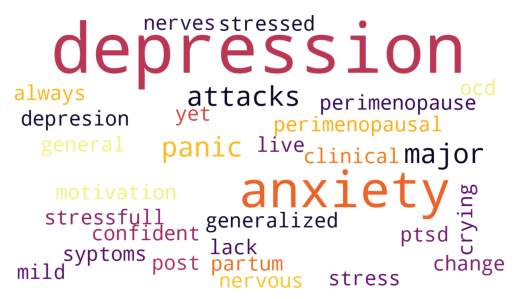

In [31]:
# Get the conditions for the specific drug
conditions = ' '.join(condition for condition in df_druglib[df_druglib['urlDrugName'] == 'lexapro']['condition'])

# Tokenize the words
words = word_tokenize(conditions)

# Get the list of stopwords
stop_words = set(stopwords.words('english'))

# Define a function to remove special characters
def clean_word(word):
    return re.sub(r'[^a-zA-Z0-9\s]', '', word)

# Remove stopwords, split words containing "/", and clean words
processed_words = []
for word in words:
    if word not in stop_words:
        if '/' in word:
            split_words = word.split('/')
            processed_words.extend(clean_word(w) for w in split_words if clean_word(w))
        else:
            cleaned_word = clean_word(word)
            if cleaned_word:
                processed_words.append(cleaned_word)

# Count the frequencies of the words
word_list = Counter(processed_words).most_common(50)

# Generate the word cloud
wc = WordCloud(
    width=1280,
    height=720,
    background_color='white',
    colormap='inferno'
).generate_from_frequencies(dict(word_list))

# Display the word cloud
plt.imshow(wc)
plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

Using word cloud visualization on *Lexapro* data, it looks like not only to treat depression but *Lexapro* can be prescribed to treat anxiety, PTSD, and panic attacks.

# Druglib.com: Acne Treatment Drugs

Next, I would like to dwell into acne treatment drugs. Here are the top 5 drugs prescribed to treat acne and the most reviewed is *Accutane*

In [32]:
keyword = 'acne'

filtered_df = df_druglib[df_druglib['condition'].str.contains(keyword)]

filtered_df.groupby('urlDrugName').agg(
    effectiveness=('effectiveness_rank', np.mean),
    sideEffects=('sideEffects_rank', np.mean),
    reviews=('commentsReview', 'count'),
    popularity=('rating', np.sum)
).sort_values(by='reviews', ascending=False).head(10)

/tmp/ipykernel_18/883454326.py:5: FutureWarning:

The provided callable <function mean at 0x78c5503684c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.

/tmp/ipykernel_18/883454326.py:5: FutureWarning:

The provided callable <function mean at 0x78c5503684c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.

/tmp/ipykernel_18/883454326.py:5: FutureWarning:

The provided callable <function sum at 0x78c55033b520> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.



,effectiveness,sideEffects,reviews,popularity
urlDrugName,,,,
accutane,4.511628,2.860465,43,333
differin,3.419355,2.064516,31,215
retin-a,3.966667,2.333333,30,231
retin-a-micro,3.750000,2.500000,20,146
minocycline,3.222222,2.333333,18,101
doxycycline,3.928571,2.785714,14,94
tazorac,4.000000,2.615385,13,98
spironolactone,4.333333,2.333333,12,98
renova,3.727273,2.272727,11,88


In [33]:
drug = 'accutane'
df_drug = df_druglib[df_druglib['urlDrugName'].str.contains(drug)]

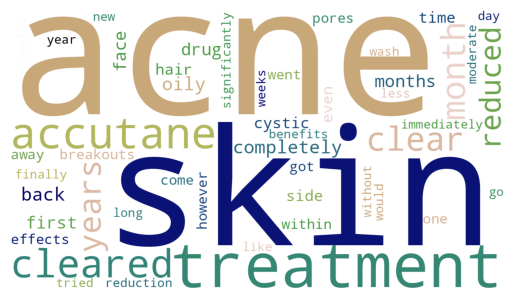

In [34]:
benefits = ' '.join(benefit for benefit in df_drug['cleaned_benefits'])
words = word_tokenize(benefits)
word_list = Counter([word for word in words]).most_common(50)

wc = WordCloud(
    width=1280,
    height=720,
    background_color='white',
    colormap='gist_earth'
    ).generate_from_frequencies(dict(word_list))

plt.imshow(wc)

plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

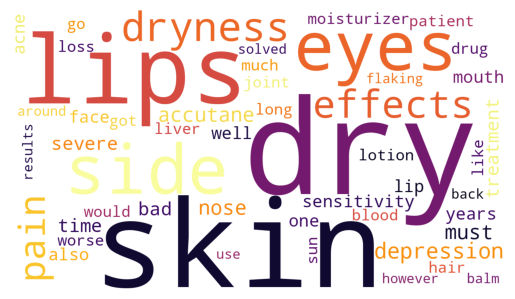

In [35]:
side_effects = ' '.join(side_effect for side_effect in df_drug['cleaned_sideEffects'])
words = word_tokenize(side_effects)
word_list = Counter([word for word in words]).most_common(50)

wc = WordCloud(
    width=1280,
    height=720,
    background_color='white',
    colormap='inferno'
    ).generate_from_frequencies(dict(word_list))

plt.imshow(wc)

plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

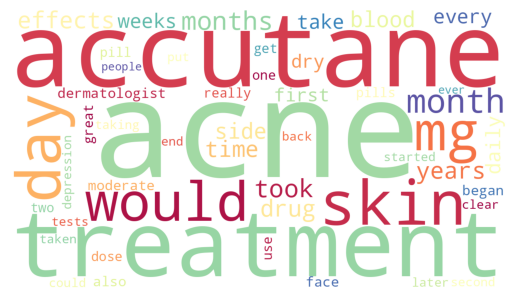

In [36]:
reviews = ' '.join(review for review in df_drug['cleaned_reviews'])
words = word_tokenize(reviews)
word_list = Counter([word for word in words]).most_common(50)

wc = WordCloud(
    width=1280,
    height=720,
    background_color='white',
    colormap='Spectral'
    ).generate_from_frequencies(dict(word_list))

plt.imshow(wc)

plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

In [37]:
map_side_effects = {}
for drug in top5drugs.index:
  df_temp = df_druglib[df_druglib['urlDrugName'].str.contains(drug)]
  # Input text
  text_temp = ' '.join(side_effects for side_effects in df_temp['sideEffectsReview'])

  sent = sent_tokenize(text_temp)
  new_sent = []

  for i in sent:
    words = word_tokenize(i)
    new_words = []

    words = ' '.join([word for word in words if drug not in word and word != '.']) + '.'
    new_sent.append(words)

  text_temp = ' '.join(new_sent)

  # Get the top 5 significant words
  top_words = extract_top_n_words(text_temp, n=5)
  map_side_effects.update({drug: top_words})

# Add new column to DataFrame
top5drugs['key_sideEffects'] = top5drugs.index.map(map_side_effects)

top5drugs

,effectiveness,sideEffects,reviews,popularity,key_sideEffects
urlDrugName,,,,,
lexapro,3.661017,2.406780,59,403,"[lexapro, day, weight, gain, feel]"
prozac,4.157895,2.315789,38,288,"[libido, feel, loss, time, appetite]"
wellbutrin,3.702703,2.243243,37,269,"[mg, mouth, dry, tinnitus, day]"
zoloft,3.971429,2.057143,35,257,"[libido, sex, nausea, sexual, day]"
effexor,3.631579,2.842105,38,248,"[felt, day, night, feeling, time]"


Generally, *Accutane* might cause dry skin judging by what keywords can be extracted from sideEffects column. It is further strengthen by the word cloud visualization earlier. The word cloud also strengthen the *Accutane** reputation in our dataset as the most popular acne treatment drugs since the reviews display a lot of "cleared", "reduced", "completely", and "significantly".

### Topic Modelling on Drug Review

Performing topic modeling on patient reviews can help uncover the main themes or topics discussed by patients in their reviews. This analysis can provide valuable insights into the most common issues, concerns, or experiences shared by patients regarding different drugs and medical conditions.

In [38]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel

# Topics on acne treatment drugs
processed_reviews = [word_tokenize(review) for review in filtered_df['cleaned_reviews']]

# Create a dictionary
dictionary = Dictionary(processed_reviews)

# Filter out tokens that appear in less than 5 reviews or more than 50% of reviews
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Create a document-term matrix
corpus = [dictionary.doc2bow(review) for review in processed_reviews]

# Train the LDA model
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=5,  # Specify the number of topics
                     passes=10,  # Number of passes through the corpus during training
                     random_state=42)  # Random state for reproducibility

# Print the topics and their top words
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.061*"face" + 0.046*"night" + 0.037*"apply" + 0.032*"cream" + 0.029*"applied" + 0.025*"every" + 0.025*"use" + 0.023*"day" + 0.023*"skin" + 0.020*"amount"')
(1, '0.082*"acne" + 0.034*"treatment" + 0.030*"accutane" + 0.027*"years" + 0.022*"would" + 0.014*"treatments" + 0.013*"tried" + 0.013*"cystic" + 0.013*"birth" + 0.012*"side"')
(2, '0.056*"acne" + 0.033*"skin" + 0.018*"started" + 0.018*"months" + 0.017*"first" + 0.014*"use" + 0.014*"weeks" + 0.014*"effects" + 0.013*"side" + 0.013*"would"')
(3, '0.056*"skin" + 0.040*"night" + 0.026*"morning" + 0.025*"cleansing" + 0.021*"doctor" + 0.020*"tretinoin" + 0.020*"used" + 0.020*"every" + 0.019*"sunscreen" + 0.017*"sensitive"')
(4, '0.059*"day" + 0.044*"mg" + 0.031*"take" + 0.028*"acne" + 0.022*"treatment" + 0.022*"daily" + 0.022*"took" + 0.021*"months" + 0.017*"taken" + 0.017*"twice"')


The numbers in the output of the LDA model represent the weight or importance of each word in the topic. These weights can be interpreted as the probability of a word appearing in a given topic. Higher weights indicate that the word is more representative or significant for that topic.

From the 5 topics extracted:

*   Topic 0: Quite general, doesn't have a clear and specific focus. The word "my", "face", "it", "was" might indicate that it could be about personal experience about using the drugs and its effects on face.
*   Topic 1: Topic appeared to be centered around acne treatment and it could be discussing their experience with their acne. ("acne", "my", "have")
*   Topic 2: Seems to focus on duration and effects of the treatment on their face. ("afer", "months", "in", "day")
*   Topic 3: Similar to Topic 1
*   Topic 4: Could be related to skincare routines ("face", "night", "skin", "use", "at")


In [39]:
# Topics on Accutane (Comments Review)
processed_reviews = [word_tokenize(review) for review in df_drug['cleaned_reviews']]

# Create a dictionary
dictionary = Dictionary(processed_reviews)

# Filter out tokens that appear in less than 5 reviews or more than 50% of reviews
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Create a document-term matrix
corpus = [dictionary.doc2bow(review) for review in processed_reviews]

# Train the LDA model
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=5,  # Specify the number of topics
                     passes=10,  # Number of passes through the corpus during training
                     random_state=42)  # Random state for reproducibility

# Print the topics and their top words
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.080*"acne" + 0.071*"time" + 0.055*"took" + 0.050*"day" + 0.049*"accutane" + 0.048*"skin" + 0.042*"mg" + 0.038*"months" + 0.037*"month" + 0.037*"years"')
(1, '0.114*"treatment" + 0.065*"would" + 0.059*"months" + 0.055*"day" + 0.043*"also" + 0.040*"weeks" + 0.037*"accutane" + 0.034*"every" + 0.031*"side" + 0.031*"effects"')
(2, '0.100*"mg" + 0.093*"day" + 0.063*"daily" + 0.059*"every" + 0.058*"two" + 0.050*"pill" + 0.047*"blood" + 0.044*"take" + 0.039*"drug" + 0.034*"tests"')
(3, '0.161*"treatment" + 0.079*"skin" + 0.066*"began" + 0.066*"month" + 0.064*"acne" + 0.048*"weeks" + 0.041*"effects" + 0.041*"would" + 0.030*"day" + 0.030*"mg"')
(4, '0.121*"acne" + 0.082*"accutane" + 0.072*"skin" + 0.049*"drug" + 0.032*"made" + 0.032*"effects" + 0.031*"tried" + 0.027*"month" + 0.026*"course" + 0.026*"depression"')


In [40]:
# Topics on Accutane (Side Effects)
processed_reviews = [word_tokenize(review) for review in df_drug['cleaned_sideEffects']]

# Create a dictionary
dictionary = Dictionary(processed_reviews)

# Filter out tokens that appear in less than 5 reviews or more than 50% of reviews
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Create a document-term matrix
corpus = [dictionary.doc2bow(review) for review in processed_reviews]

# Train the LDA model
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=6,  # Specify the number of topics
                     passes=10,  # Number of passes through the corpus during training
                     random_state=42)  # Random state for reproducibility

# Print the topics and their top words
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.307*"eyes" + 0.223*"depression" + 0.138*"sensitivity" + 0.127*"severe" + 0.110*"nose" + 0.016*"side" + 0.010*"pain" + 0.009*"effects" + 0.009*"accutane" + 0.009*"well"')
(1, '0.320*"mouth" + 0.233*"lip" + 0.232*"sensitivity" + 0.018*"dryness" + 0.018*"depression" + 0.018*"eyes" + 0.018*"treatment" + 0.018*"nose" + 0.018*"also" + 0.018*"severe"')
(2, '0.258*"accutane" + 0.176*"treatment" + 0.131*"severe" + 0.095*"lip" + 0.095*"well" + 0.094*"also" + 0.031*"sensitivity" + 0.023*"eyes" + 0.015*"dryness" + 0.014*"depression"')
(3, '0.338*"dryness" + 0.247*"pain" + 0.136*"eyes" + 0.065*"lip" + 0.053*"side" + 0.041*"mouth" + 0.040*"accutane" + 0.016*"depression" + 0.014*"severe" + 0.014*"also"')
(4, '0.242*"nose" + 0.205*"treatment" + 0.204*"well" + 0.107*"also" + 0.059*"effects" + 0.058*"mouth" + 0.058*"pain" + 0.009*"lip" + 0.008*"eyes" + 0.008*"depression"')
(5, '0.315*"side" + 0.297*"effects" + 0.107*"depression" + 0.100*"accutane" + 0.062*"also" + 0.062*"severe" + 0.011*"eyes" + 

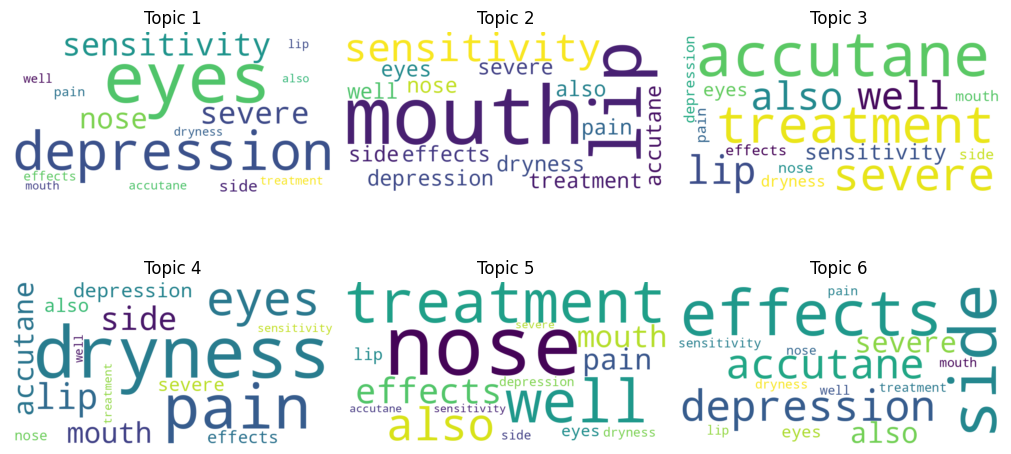

In [41]:
# Function to plot word cloud for a given topic
def plot_word_cloud(lda_model, topic_number, ax):
    topic_words = dict(lda_model.show_topic(topic_number, 20))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_words)

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'Topic {topic_number + 1}')

# Plot word clouds in a 3x2 grid
fig, axes = plt.subplots(2, 3, figsize=(10, 5), constrained_layout=True)

# Iterate through each subplot and plot the corresponding word cloud
for i, ax in enumerate(axes.flatten()):
    if i < lda_model.num_topics:
        plot_word_cloud(lda_model, i, ax)
    else:
        fig.delaxes(ax)  # Remove empty subplots

plt.show()

There are 5 topics that i extracted, the consumers usually talks about dry skin in the sideEffects section but interestingly there are some mentions about depression. If we look into the raw data, there are a few comments about *Accutane* causing depression.

# Drugs.com Dataset

In [42]:
train_path = '/kaggle/input/patient-ratings-identifying-best-drugs/Drug Reviews (Drugs.com)/drugsComTrain_raw.csv'
test_path = '/kaggle/input/patient-ratings-identifying-best-drugs/Drug Reviews (Drugs.com)/drugsComTest_raw.csv'
df_drugscom_train = pd.read_csv(train_path)
df_drugscom_test = pd.read_csv(test_path)

In [43]:
df_drugscom = pd.concat([df_drugscom_train,df_drugscom_test])
df_drugscom = df_drugscom.drop(columns='Unnamed: 0')
df_drugscom.reset_index(drop=True,inplace=True)

In [44]:
df_drugscom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215063 entries, 0 to 215062
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   drugName     215063 non-null  object 
 1   condition    213869 non-null  object 
 2   review       215063 non-null  object 
 3   rating       215063 non-null  float64
 4   date         215063 non-null  object 
 5   usefulCount  215063 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 9.8+ MB


In [45]:
# Dropping null values since only a few rows containing null values
df_drugscom = df_drugscom.dropna()
df_drugscom.info()

<class 'pandas.core.frame.DataFrame'>
Index: 213869 entries, 0 to 215062
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   drugName     213869 non-null  object 
 1   condition    213869 non-null  object 
 2   review       213869 non-null  object 
 3   rating       213869 non-null  float64
 4   date         213869 non-null  object 
 5   usefulCount  213869 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 11.4+ MB


In [46]:
df_drugscom.head()

,drugName,condition,review,rating,date,usefulCount
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


# Drugs.com Data Preprocessing

In [47]:
df_drugscom['cleaned_review'] = df_drugscom['review'].apply(preprocess_text)

In [48]:
sentiment_analyzer(df_drugscom,'cleaned_review')

In [49]:
df_sentiment = df_drugscom.groupby('sentiment_label').agg(
    count=('sentiment_score', 'count'),
    avg_value=('sentiment_score', 'mean')
)

df_sentiment.rename(columns={'count': 'Total Reviews', 'avg_value': 'Avg. Sentiment Score'}, inplace=True)
df_sentiment.index.names = ['Sentiment Label']

# Define colors for each sentiment label
colors = {
    'Positive': '#00CC96',
    'Neutral': '#636EFA',
    'Negative': '#EF553B'
}

# Create a pie chart using Plotly Express
fig = px.pie(
    df_sentiment.reset_index(),
    names='Sentiment Label',
    values='Total Reviews',
    color='Sentiment Label',
    width=600,
    height=600,
    color_discrete_map=colors
)

fig.update_traces(
    hoverinfo='label+value',
    textinfo='label+percent'
)
fig.update_layout(
    title_text='Review Section Sentiment Analysis',
    title_x=0.5,
    title_font_size=20)


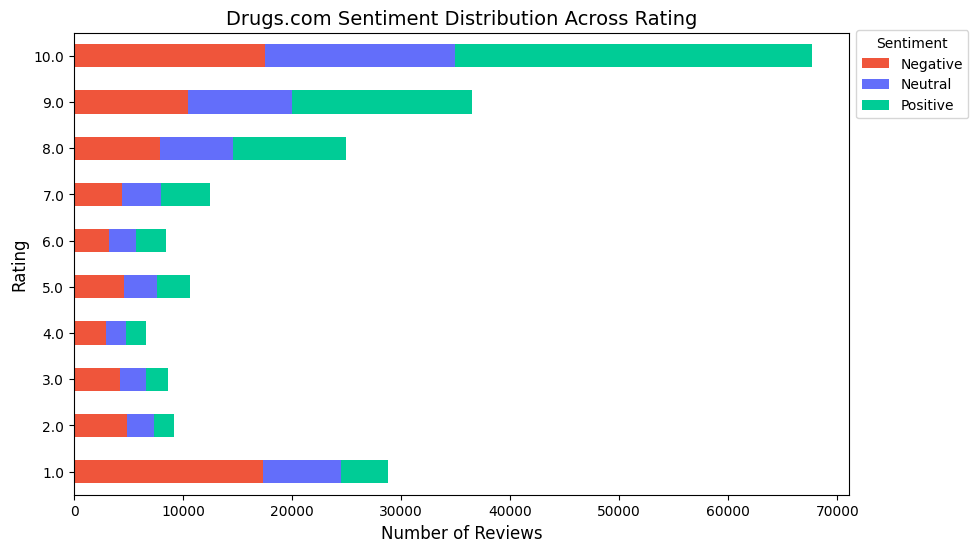

In [50]:
# Plotting horizontal bar chart
sentiment_order = [
    'Negative',
    'Neutral',
    'Positive'
]

sentiment_color = sns.color_palette("Reds", len(sentiment_order))
data_bar2 = df_drugscom.pivot_table(index='rating',columns='sentiment_label',values='review',aggfunc='count')
data_bar2.sort_index()

ax = data_bar2.plot(kind='barh',stacked=True,color=['#EF553B','#636EFA','#00CC96'],figsize=(10, 6))

plt.title('Drugs.com Sentiment Distribution Across Rating', fontsize=14)
plt.ylabel('Rating', fontsize=12)
plt.xlabel('Number of Reviews', fontsize=12)

# Customize legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='Sentiment', bbox_to_anchor=(1,1.02), loc='upper left')

plt.show()

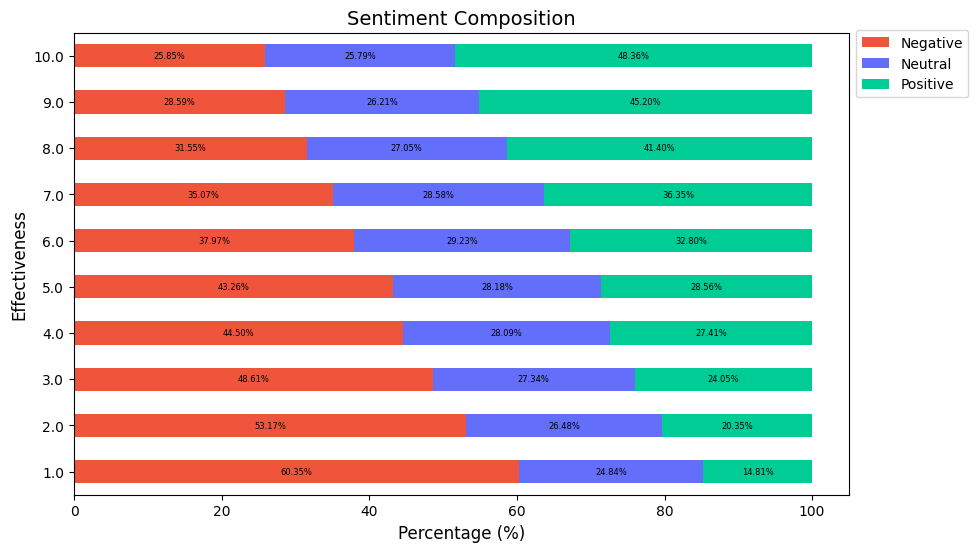

In [51]:
# Calculate row-wise sum for normalization
row_sums = data_bar2.sum(axis=1)

# Calculate percentages
data_percent = data_bar2.div(row_sums, axis=0) * 100

# Plotting
ax = data_percent.plot.barh(stacked=True,color=['#EF553B','#636EFA','#00CC96'],figsize=(10, 6))
plt.title('Sentiment Composition', fontsize=14)
plt.ylabel('Effectiveness', fontsize=12)
plt.xlabel('Percentage (%)', fontsize=12)

for c in ax.containers:

    # customize the label to account for cases when there might not be a bar section
    labels = [f'{w:.2f}%' if (w := v.get_width()) > 0 else '' for v in c ]

    # set the bar label
    ax.bar_label(c, labels=labels, label_type='center', fontsize=6)

ax.legend(bbox_to_anchor=(1,1.02), loc='upper left')

plt.show()

In [52]:
data_bar2

sentiment_label,Negative,Neutral,Positive
rating,,,
1.0,17363,7146,4260
2.0,4893,2437,1873
3.0,4211,2368,2083
4.0,2947,1860,1815
5.0,4607,3001,3042
6.0,3191,2456,2756
7.0,4373,3564,4533
8.0,7858,6738,10313
9.0,10435,9567,16497


In [53]:
data_percent

sentiment_label,Negative,Neutral,Positive
rating,,,
1.0,60.353158,24.839237,14.807605
2.0,53.167445,26.480495,20.352059
3.0,48.614639,27.337797,24.047564
4.0,44.503171,28.088191,27.408638
5.0,43.258216,28.178404,28.563380
6.0,37.974533,29.227657,32.797810
7.0,35.068164,28.580593,36.351243
8.0,31.546830,27.050464,41.402706
9.0,28.589824,26.211677,45.198499


Using sentiment analysis, we can conclude that as rating goes up te distribution of sentiment on review section tends to be positive.

In [54]:
most_reviewed_med_condition = df_drugscom.groupby('condition').agg(
    reviews=('review', 'count')
).sort_values(by='reviews', ascending=False).head(10)

conditions = df_drugscom['condition'].unique()

print(len(conditions),' different conditions')
print('sample:')

for index, row in most_reviewed_med_condition.iterrows():
    print(f"{index}: {row['reviews']} reviews")

916  different conditions
sample:
Birth Control: 38436 reviews
Depression: 12164 reviews
Pain: 8245 reviews
Anxiety: 7812 reviews
Acne: 7435 reviews
Bipolar Disorde: 5604 reviews
Insomnia: 4904 reviews
Weight Loss: 4857 reviews
Obesity: 4757 reviews
ADHD: 4509 reviews


# Drugs.com Birth Control Analysis

Using code I developed earlier to extract keywords from review section, we can see that the most reviewed drug for birth control is Etonogestrel. It has moderate rating compared to Levonorgestel and Skyla which have higher rating. Let's look into them to get insights what made Etonogestrel has mixed ratings.

In [55]:
keyword = 'Birth Control'

filtered_df = df_drugscom[df_drugscom['condition'].str.contains(keyword)]

top10drugs_birth = filtered_df.groupby('drugName').agg(
    reviews=('review', 'count'),
    avg_rating=('rating',np.mean)
).sort_values(by='reviews', ascending=False).head(10)

map_side_effects = {}
for drug in top10drugs_birth.index:
  df_temp = df_drugscom[df_drugscom['drugName'].str.contains(drug)]
  # Input text
  text_temp = ' '.join(side_effects for side_effects in df_temp['cleaned_review'])

  sent = sent_tokenize(text_temp)
  new_sent = []

  for i in sent:
    words = word_tokenize(i)
    new_words = []

    words = ' '.join([word for word in words if drug not in word and word != '.']) + '.'
    new_sent.append(words)

  text_temp = ' '.join(new_sent)

  # Get the top 5 significant words
  top_words = extract_top_n_words(text_temp, n=5)
  map_side_effects.update({drug: top_words})

# Add new column to DataFrame
top10drugs_birth['keywords_review'] = top10drugs_birth.index.map(map_side_effects)

top10drugs_birth

/tmp/ipykernel_18/1771038930.py:5: FutureWarning:

The provided callable <function mean at 0x78c5503684c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.



,reviews,avg_rating,keywords_review
drugName,,,
Etonogestrel,4394,5.829768,"[period, months, weight, nexplanon, birth]"
Ethinyl estradiol / norethindrone,3081,5.646868,"[pill, period, months, control, birth]"
Levonorgestrel,2884,7.038835,"[period, days, pill, day, cramps]"
Nexplanon,2883,5.649670,"[period, months, nexplanon, weight, control]"
Ethinyl estradiol / levonorgestrel,2107,5.867584,"[pill, period, control, birth, months]"
Ethinyl estradiol / norgestimate,2097,5.876490,"[pill, control, birth, period, acne]"
Implanon,1496,6.175134,"[implanon, period, months, weight, birth]"
Mirena,1320,6.982576,"[months, period, insertion, pain, years]"
Skyla,1074,7.243948,"[skyla, cramps, insertion, period, bad]"


In [56]:
df_etonogestrel = df_drugscom[df_drugscom['drugName'] == 'Etonogestrel']
df_levonorgestrel = df_drugscom[df_drugscom['drugName'] == 'Levonorgestrel']
df_skyla = df_drugscom[df_drugscom['drugName'] == 'Skyla']

# Topics on Etonogestrel
processed_reviews = [word_tokenize(review) for review in df_etonogestrel['cleaned_review']]

# Create a dictionary
dictionary = Dictionary(processed_reviews)

# Filter out tokens that appear in less than 5 reviews or more than 50% of reviews
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Create a document-term matrix
corpus = [dictionary.doc2bow(review) for review in processed_reviews]

# Train the LDA model
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=6,  # Specify the number of topics
                     passes=10,  # Number of passes through the corpus during training
                     random_state=42)  # Random state for reproducibility

# Print the topics and their top words
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.017*"got" + 0.015*"days" + 0.013*"month" + 0.013*"implanon" + 0.013*"first" + 0.012*"weight" + 0.012*"nexplanon" + 0.011*"bleeding" + 0.011*"weeks" + 0.011*"get"')
(1, '0.027*"mood" + 0.025*"swings" + 0.023*"depression" + 0.022*"control" + 0.021*"birth" + 0.019*"sex" + 0.019*"anxiety" + 0.016*"drive" + 0.014*"amp" + 0.012*"weight"')
(2, '0.020*"got" + 0.018*"get" + 0.013*"implant" + 0.013*"weight" + 0.012*"time" + 0.012*"bleeding" + 0.011*"first" + 0.011*"getting" + 0.011*"since" + 0.010*"weeks"')
(3, '0.023*"pill" + 0.023*"control" + 0.023*"birth" + 0.018*"bleeding" + 0.017*"would" + 0.016*"nexplanon" + 0.013*"take" + 0.012*"periods" + 0.011*"pills" + 0.011*"every"')
(4, '0.039*"side" + 0.034*"effects" + 0.018*"nexplanon" + 0.017*"implant" + 0.016*"pain" + 0.014*"birth" + 0.013*"years" + 0.012*"arm" + 0.012*"control" + 0.010*"rsquo"')
(5, '0.028*"weight" + 0.018*"implanon" + 0.018*"gain" + 0.017*"since" + 0.016*"love" + 0.015*"insertion" + 0.012*"periods" + 0.012*"first" + 0.01

In [57]:
# Topics on Levonorgestrel
processed_reviews = [word_tokenize(review) for review in df_levonorgestrel['cleaned_review']]

# Create a dictionary
dictionary = Dictionary(processed_reviews)

# Filter out tokens that appear in less than 5 reviews or more than 50% of reviews
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Create a document-term matrix
corpus = [dictionary.doc2bow(review) for review in processed_reviews]

# Train the LDA model
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=6,  # Specify the number of topics
                     passes=10,  # Number of passes through the corpus during training
                     random_state=42)  # Random state for reproducibility

# Print the topics and their top words
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.017*"birth" + 0.016*"control" + 0.014*"mirena" + 0.011*"months" + 0.011*"years" + 0.011*"insertion" + 0.010*"skyla" + 0.010*"would" + 0.010*"first" + 0.010*"get"')
(1, '0.027*"days" + 0.025*"cramps" + 0.020*"day" + 0.019*"spotting" + 0.019*"insertion" + 0.017*"got" + 0.016*"bleeding" + 0.013*"pain" + 0.012*"painful" + 0.012*"cramping"')
(2, '0.025*"days" + 0.024*"took" + 0.023*"plan" + 0.022*"b" + 0.016*"pill" + 0.014*"later" + 0.014*"sex" + 0.013*"day" + 0.012*"got" + 0.012*"week"')
(3, '0.042*"mirena" + 0.021*"months" + 0.021*"bleeding" + 0.015*"years" + 0.013*"removed" + 0.012*"weight" + 0.012*"since" + 0.012*"periods" + 0.010*"weeks" + 0.010*"one"')
(4, '0.034*"pill" + 0.027*"took" + 0.020*"sex" + 0.017*"plan" + 0.016*"day" + 0.016*"b" + 0.015*"days" + 0.014*"got" + 0.014*"hours" + 0.013*"time"')
(5, '0.029*"pain" + 0.018*"insertion" + 0.015*"felt" + 0.014*"cramps" + 0.013*"like" + 0.013*"took" + 0.013*"cramping" + 0.011*"bad" + 0.011*"got" + 0.011*"inserted"')


In [58]:
# Topics on Skyla
processed_reviews = [word_tokenize(review) for review in df_skyla['cleaned_review']]

# Create a dictionary
dictionary = Dictionary(processed_reviews)

# Filter out tokens that appear in less than 5 reviews or more than 50% of reviews
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Create a document-term matrix
corpus = [dictionary.doc2bow(review) for review in processed_reviews]

# Train the LDA model
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=6,  # Specify the number of topics
                     passes=10,  # Number of passes through the corpus during training
                     random_state=42)  # Random state for reproducibility

# Print the topics and their top words
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.020*"day" + 0.016*"period" + 0.015*"took" + 0.013*"inserted" + 0.013*"cramping" + 0.012*"like" + 0.011*"procedure" + 0.011*"felt" + 0.011*"days" + 0.009*"amp"')
(1, '0.014*"iud" + 0.013*"get" + 0.012*"painful" + 0.011*"feel" + 0.011*"quot" + 0.011*"day" + 0.009*"like" + 0.009*"felt" + 0.009*"take" + 0.008*"reviews"')
(2, '0.014*"got" + 0.013*"day" + 0.013*"cramping" + 0.013*"went" + 0.010*"like" + 0.010*"amp" + 0.010*"take" + 0.009*"iud" + 0.009*"felt" + 0.009*"took"')
(3, '0.020*"period" + 0.018*"months" + 0.015*"got" + 0.014*"get" + 0.013*"days" + 0.011*"month" + 0.011*"first" + 0.010*"bad" + 0.010*"would" + 0.009*"iud"')
(4, '0.018*"got" + 0.014*"bad" + 0.014*"cramping" + 0.013*"like" + 0.013*"took" + 0.012*"painful" + 0.011*"inserted" + 0.011*"felt" + 0.011*"day" + 0.011*"period"')
(5, '0.018*"period" + 0.018*"like" + 0.014*"quot" + 0.013*"bad" + 0.010*"got" + 0.010*"first" + 0.010*"cervix" + 0.010*"feel" + 0.009*"cramping" + 0.008*"painful"')


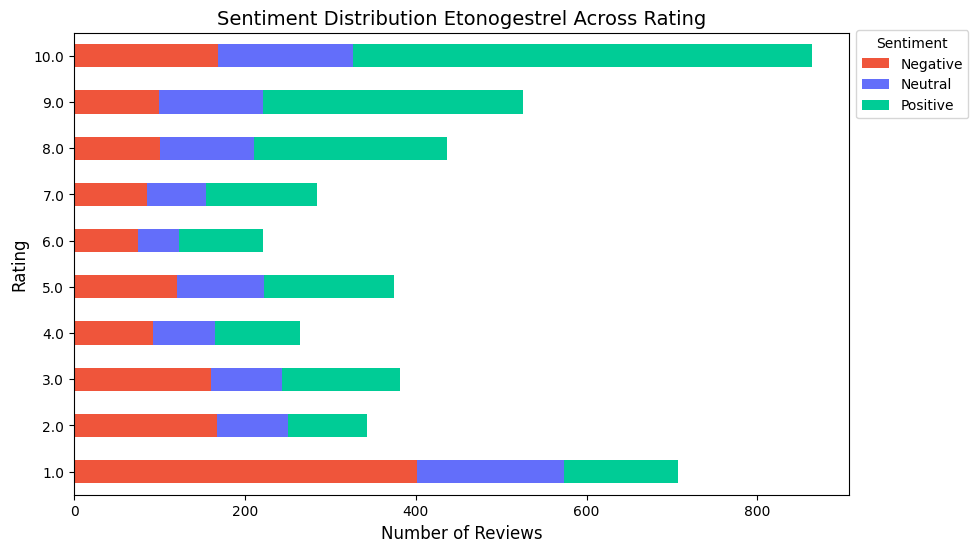

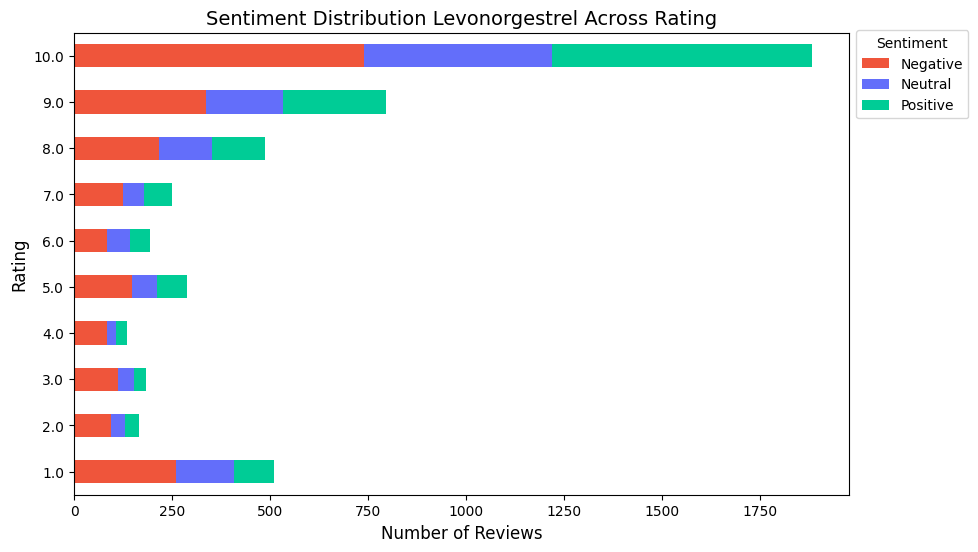

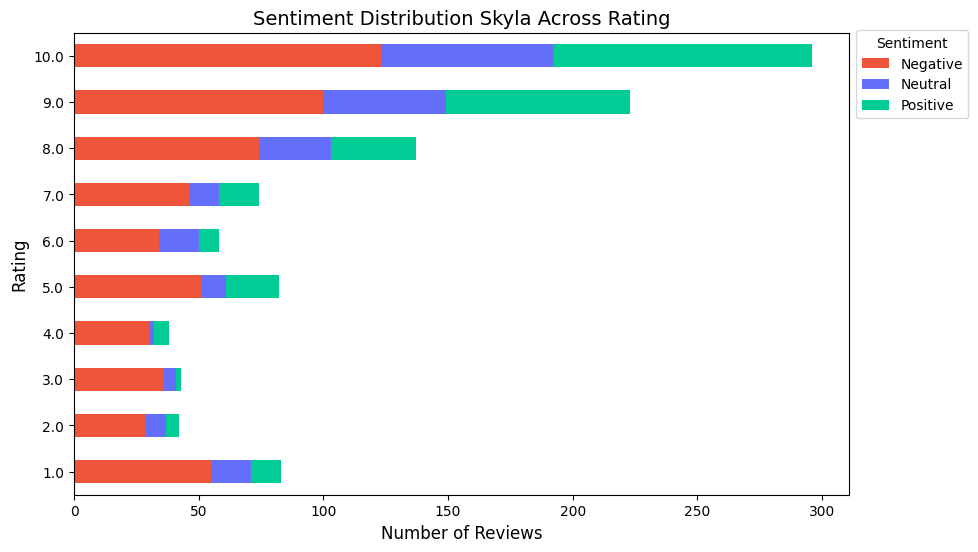

In [59]:
def plot_sentiment_distributions(dfs, titles, color_palette):
    for df, title in zip(dfs, titles):
        sentiment_order = [
            'Negative',
            'Neutral',
            'Positive'
        ]

        data_bar = df.pivot_table(index='rating', columns='sentiment_label', values='review', aggfunc='count')
        data_bar = data_bar.reindex(sentiment_order, axis=1)
        data_bar = data_bar.sort_index()

        ax = data_bar.plot(kind='barh', stacked=True, color=color_palette, figsize=(10, 6))

        plt.title(title, fontsize=14)
        plt.ylabel('Rating', fontsize=12)
        plt.xlabel('Number of Reviews', fontsize=12)

        # Customize legend
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, title='Sentiment', bbox_to_anchor=(1, 1.02), loc='upper left')

        plt.show()

dfs = [df_etonogestrel, df_levonorgestrel, df_skyla]  # List of DataFrames
titles = ['Sentiment Distribution Etonogestrel Across Rating', 'Sentiment Distribution Levonorgestrel Across Rating', 'Sentiment Distribution Skyla Across Rating']
color_palette = ['#EF553B', '#636EFA', '#00CC96']

plot_sentiment_distributions(dfs, titles, color_palette)

Seems like more people react negatively when consuming Etonogestrel compared to other drugs. Let's find out what topics people that react negatively (giving 1 rating) to Etonogestrel and the other drugs.

In [60]:
# Topics on Etonogestrel that has 1 rating
processed_reviews = [word_tokenize(review) for review in df_etonogestrel[df_etonogestrel['rating'] == 1]['cleaned_review']]

# Create a dictionary
dictionary = Dictionary(processed_reviews)

# Filter out tokens that appear in less than 5 reviews or more than 50% of reviews
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Create a document-term matrix
corpus = [dictionary.doc2bow(review) for review in processed_reviews]

# Train the LDA model
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=6,  # Specify the number of topics
                     passes=10,  # Number of passes through the corpus during training
                     random_state=42)  # Random state for reproducibility

# Print the topics and their top words
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.019*"period" + 0.018*"implant" + 0.014*"get" + 0.013*"got" + 0.012*"time" + 0.011*"bleeding" + 0.011*"years" + 0.011*"would" + 0.011*"sex" + 0.009*"removed"')
(1, '0.022*"like" + 0.014*"mood" + 0.014*"horrible" + 0.012*"removed" + 0.012*"got" + 0.012*"felt" + 0.012*"since" + 0.011*"swings" + 0.010*"thing" + 0.010*"would"')
(2, '0.024*"period" + 0.020*"got" + 0.016*"bleeding" + 0.015*"never" + 0.014*"birth" + 0.014*"control" + 0.014*"get" + 0.013*"since" + 0.011*"would" + 0.011*"nexplanon"')
(3, '0.021*"side" + 0.020*"weight" + 0.018*"effects" + 0.017*"would" + 0.016*"get" + 0.015*"control" + 0.015*"getting" + 0.014*"birth" + 0.014*"year" + 0.012*"implant"')
(4, '0.017*"weight" + 0.015*"acne" + 0.015*"got" + 0.014*"nexplanon" + 0.014*"since" + 0.012*"get" + 0.012*"month" + 0.012*"gained" + 0.012*"mood" + 0.012*"implanon"')
(5, '0.021*"control" + 0.021*"birth" + 0.019*"bleeding" + 0.018*"get" + 0.016*"got" + 0.012*"nexplanon" + 0.010*"removed" + 0.010*"like" + 0.010*"first" + 0.01

In [61]:
# Input text
text = ' '.join(side_effects for side_effects in df_etonogestrel[df_etonogestrel['rating'] == 1]['cleaned_review'])

# Get the top 5 significant words
top_words = extract_top_n_words(text, n=5)
print(top_words)

['months', 'period', 'birth', 'control', 'weight']


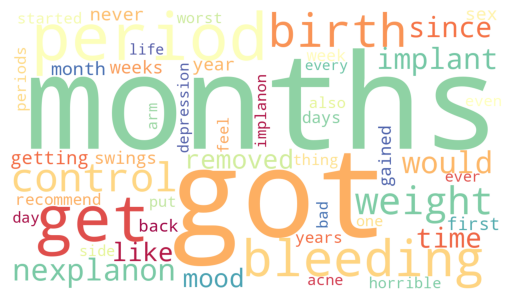

In [62]:
reviews = ' '.join(review for review in df_etonogestrel[df_etonogestrel['rating'] == 1]['cleaned_review'])
words = word_tokenize(reviews)
word_list = Counter([word for word in words]).most_common(50)

wc = WordCloud(
    width=1280,
    height=720,
    background_color='white',
    colormap='Spectral'
    ).generate_from_frequencies(dict(word_list))

plt.imshow(wc)

plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

Seems like people who reacts negatively to consuming Etonogestrel experienced some kind of weight gain and bleeding.

In [63]:
# Input text
text = ' '.join(side_effects for side_effects in df_levonorgestrel[df_levonorgestrel['rating'] == 1]['cleaned_review'])

# Get the top 5 significant words
top_words = extract_top_n_words(text, n=5)
print(top_words)

['mirena', 'pain', 'period', 'months', 'weeks']


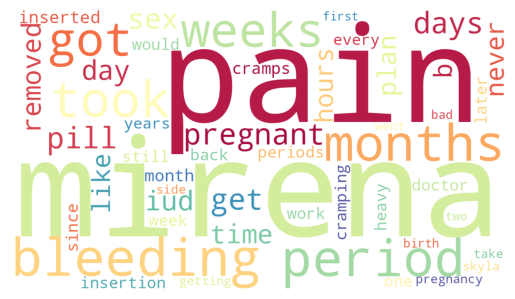

In [64]:
reviews = ' '.join(review for review in df_levonorgestrel[df_levonorgestrel['rating'] == 1]['cleaned_review'])
words = word_tokenize(reviews)
word_list = Counter([word for word in words]).most_common(50)

wc = WordCloud(
    width=1280,
    height=720,
    background_color='white',
    colormap='Spectral'
    ).generate_from_frequencies(dict(word_list))

plt.imshow(wc)

plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

In [65]:
# Input text
text = ' '.join(side_effects for side_effects in df_skyla[df_skyla['rating'] == 1]['cleaned_review'])

# Get the top 5 significant words
top_words = extract_top_n_words(text, n=5)
print(top_words)

['skyla', 'pain', 'cramps', 'months', 'iud']


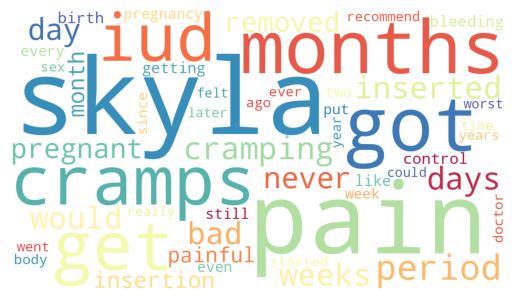

In [66]:
reviews = ' '.join(review for review in df_skyla[df_skyla['rating'] == 1]['cleaned_review'])
words = word_tokenize(reviews)
word_list = Counter([word for word in words]).most_common(50)

wc = WordCloud(
    width=1280,
    height=720,
    background_color='white',
    colormap='Spectral'
    ).generate_from_frequencies(dict(word_list))

plt.imshow(wc)

plt.axis('off')
plt.margins(x=0, y=0)
plt.show()